# Segmenting and Clustering Neighborhoods in Toronto

## Importing Libraries

In [9]:
# import all necessary libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [10]:
import requests
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M#Toronto_-_103_FSAs').text

## Part 1 : Web scraping is using the BeautifulSoup package

In [13]:
soup = BeautifulSoup(website_url, 'html.parser')

In [17]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### Data Pre Processing

In [20]:
# droping rows having "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [21]:
# Checking missing values
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [22]:
# Check if we still have any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

,PostalCode,Borough,Neighborhood


In [23]:
df = df_dropna
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [24]:
# shape of dataframe
df.shape

(103, 3)

In [25]:
# Cleaned Data in csv format
df.to_csv('Neighborhoods in Toronto.csv')

## Part 2 : To build a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data

In [31]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [30]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude_x,Longitude_x,Latitude_y,Longitude_y,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656,43.753259,-79.329656,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572,43.725882,-79.315572,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,43.654260,-79.360636,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,43.718518,-79.464763,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,43.662301,-79.389494,43.662301,-79.389494


In [32]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

## Data Visualization of all Borough present in Toronto

In [33]:
df_toronto = df
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude_x,Longitude_x,Latitude_y,Longitude_y,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656,43.753259,-79.329656,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572,43.725882,-79.315572,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,43.654260,-79.360636,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,43.718518,-79.464763,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,43.662301,-79.389494,43.662301,-79.389494


In [34]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [35]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


In [36]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [37]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

## Using Foursquare API to get the top 150 venues that are in Lawrence Park within a radius of 500 meters

In [40]:
CLIENT_ID = 'HVTCMEB4C5WADHXRKQN1X5I4WHHG4N3ULOTY1FH5SSOO0SNE' # your Foursquare ID
CLIENT_SECRET = '3KRMF32OQ0JHTWQEKMVB0AY5KU1MTVDBW5CJRKINI0CKHHNW' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

In [41]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 150 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [43]:
toronto_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2129,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Jim & Maria's No Frills,43.631152,-79.518617,Grocery Store
2130,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Royal Canadian Legion #210,43.628855,-79.518903,Social Club
2131,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2132,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store
2133,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym


In [44]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",5,5,5,5,5,5
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15


### Unique venues in all neighborhood 

In [45]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques vanue categories.


In [46]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Fast Food Restaurant' 'Food & Drink Shop' 'Hockey Arena'
 'Coffee Shop' 'Portuguese Restaurant' 'Pizza Place' 'Bakery'
 'Distribution Center' 'Restaurant' 'Spa' 'Gym / Fitness Center' 'Pub'
 'Breakfast Spot' 'Historic Site' 'Chocolate Shop' 'Farmers Market'
 'Performing Arts Venue' 'Dessert Shop' 'French Restaurant'
 'Mexican Restaurant' 'Theater' 'Yoga Studio' 'Shoe Store' 'Event Space'
 'Café' 'Asian Restaurant' 'Electronics Store' 'Art Gallery' 'Bank'
 'Beer Store' 'Health Food Store' 'Antique Shop' 'Playground' 'Boutique'
 'Furniture / Home Store' 'Vietnamese Restaurant' 'Clothing Store'
 'Accessories Store' 'Arts & Crafts Store' 'Miscellaneous Shop'
 'Italian Restaurant' 'Beer Bar' 'Sushi Restaurant' 'Creperie'
 'Burrito Place' 'Fried Chicken Joint' 'Hobby Shop' 'Diner'
 'Japanese Restaurant' 'Smoothie Shop' 'Sandwich Place' 'Gym'
 'College Auditorium' 'Bar' 'Music Venue' 'Caribbean Restaurant'
 'Athletics & Sports' 'Gastropub' 'Pharmacy' 'Pet Sto

## Data Analysis

In [47]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2134, 275)


,Neighborhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [48]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(99, 275)


,Neighborhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [49]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head()

,Neighborhoods,Italian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.074074


In [50]:
# rename column "Neighborhoods" to "Neighborhood"
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

## Clustering

#### Finding best k value

In [51]:
X = ita.drop(['Neighborhood'], axis=1)

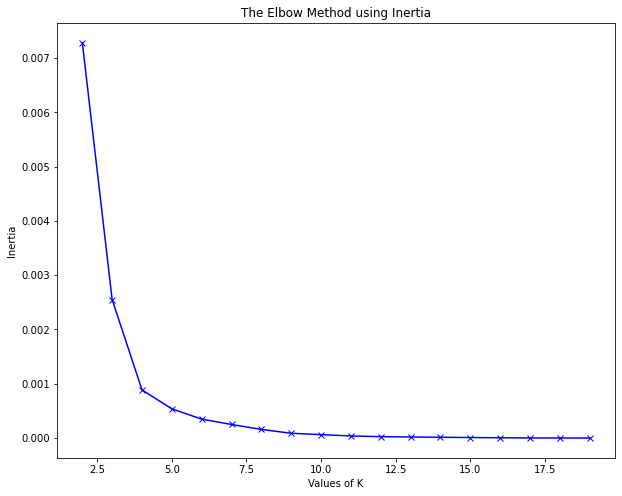

In [52]:
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [53]:
k = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 2, 0, 1, 0, 0])

In [54]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

In [55]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [56]:
to_merged.head()

,Neighborhood,Italian Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.074074,3


In [57]:

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2134, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


In [58]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(2134, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
84,"The Danforth West, Riverdale",0.071429,3,43.679557,-79.352188,Demetres,43.677683,-79.351608,Dessert Shop
84,"The Danforth West, Riverdale",0.071429,3,43.679557,-79.352188,The Big Carrot Organic Juice Bar,43.677438,-79.352683,Juice Bar
84,"The Danforth West, Riverdale",0.071429,3,43.679557,-79.352188,Christina's On The Danforth,43.678240,-79.349185,Greek Restaurant
84,"The Danforth West, Riverdale",0.071429,3,43.679557,-79.352188,Don Valley Trail,43.676331,-79.353923,Trail
64,"Parkdale, Roncesvalles",0.071429,3,43.648960,-79.456325,Scout,43.650970,-79.450866,Gift Shop


In [59]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']


42

##  Visualize Clustering 

In [61]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [62]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

,Neighborhood,Italian Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.074074,3


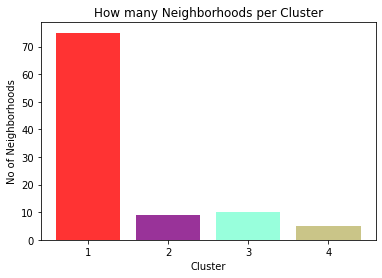

In [63]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [64]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    75
2    10
1     9
3     5
Name: Cluster Labels, dtype: int64

## Analysis of each Cluster
#### Cluster 1 : Purple

In [66]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

,Borough,Neighborhood
0,North York,Parkwoods
1,North York,Victoria Village
2,Downtown Toronto,"Regent Park, Harbourfront"
3,North York,"Lawrence Manor, Lawrence Heights"
4,Queen's Park,Ontario Provincial Government


In [67]:
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Don Mills South,0.052632,1,43.7259,-79.340923,Fitness Connection,43.727473,-79.341707,Gym
1,North York,Don Mills South,0.052632,1,43.7259,-79.340923,Sorento Restaurant,43.726575,-79.341989,Italian Restaurant
2,North York,Don Mills South,0.052632,1,43.7259,-79.340923,Swiss Chalet,43.726747,-79.341625,Restaurant
3,North York,Don Mills South,0.052632,1,43.7259,-79.340923,Japanese Canadian Cultural Centre,43.726429,-79.334971,Art Gallery
4,North York,Don Mills South,0.052632,1,43.7259,-79.340923,Skiis and Biikes,43.726351,-79.342977,Bike Shop


#### Cluster 2 : Red

In [68]:
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,0.0,0,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
1,North York,Parkwoods,0.0,0,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,North York,Parkwoods,0.0,0,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
3,North York,Victoria Village,0.0,0,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
4,North York,Victoria Village,0.0,0,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


#### Cluster 3 : Turquoise

In [69]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Christie,0.0625,3,43.669542,-79.422564,Fiesta Farms,43.668471,-79.420485,Grocery Store
1,Downtown Toronto,Christie,0.0625,3,43.669542,-79.422564,Contra Cafe,43.669107,-79.426105,Café
2,Downtown Toronto,Christie,0.0625,3,43.669542,-79.422564,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant
3,Downtown Toronto,Christie,0.0625,3,43.669542,-79.422564,Starbucks,43.671530,-79.421400,Coffee Shop
4,Downtown Toronto,Christie,0.0625,3,43.669542,-79.422564,Scout and Cash Caffe,43.667360,-79.419938,Café


#### Cluster 4 : Blue

In [70]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Queen's Park,Ontario Provincial Government,0.030303,2,43.662301,-79.389494,Queen's Park,43.663946,-79.392180,Park
1,Queen's Park,Ontario Provincial Government,0.030303,2,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant
2,Queen's Park,Ontario Provincial Government,0.030303,2,43.662301,-79.389494,Nando's,43.661728,-79.386391,Portuguese Restaurant
3,Queen's Park,Ontario Provincial Government,0.030303,2,43.662301,-79.389494,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop
4,Queen's Park,Ontario Provincial Government,0.030303,2,43.662301,-79.389494,Bar Volo,43.665462,-79.385692,Beer Bar
